# 3th_homework

### Import Section

In [1]:
import numpy as np
import pandas as pd

from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin

from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import FunctionTransformer

from sklearn.linear_model import LogisticRegression

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

from sklearn.metrics import precision_recall_curve

### Global Settings Section

In [2]:
random_state_global = 0

## 1. обучить несколько разных моделей на наборе данных ССЗ (train_case2.csv): логрег, бустинг, лес и т.д - на ваш выбор 2-3 варианта

In [3]:
df_data = pd.read_csv('train_case2.csv', sep=';')

In [4]:
df_data.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


##### Объявим классы для выбора и исключения признаков.

In [5]:
class FeatureSelectorNumerical(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return X[[self.column]]


class FeatureSelectorCategorical(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return X[self.column]


class FeatureDeletion(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return X.drop(columns=[self.column])


class FeatureDropDuplicates(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return X.drop_duplicates()


class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in test_columns:
            if col_ not in self.columns:
                X[col_] = 0
        return X[self.columns]

### LogRess

##### Выполним предобработку данных для логистической регрессии при помощи Pipeline.

#### Списки признаков для предобработки.

In [6]:
list_features_numerical = ['age', 'height', 'weight', 'ap_hi', 'ap_lo']
list_features_categorical = ['gender', 'cholesterol', 'gluc']
list_features_deletion = ['id']

list_columns = ['age', 'gender', 'height', 'weight', 'ap_hi', 'ap_lo',
                'cholesterol', 'gluc', 'smoke', 'alco', 'active']

##### Реализуем Pipeline для преобработки данных.

In [7]:
list_pipelines_numerical = []

for feature in list_features_numerical:
    pipeline_new = Pipeline([
        (f'fsn_{feature}', FeatureSelectorNumerical(column=feature)),
        (f'ss_{feature}', StandardScaler())
    ])
    
    list_pipelines_numerical.append((feature, pipeline_new))


list_pipelines_categorical = []

for feature in list_features_categorical:
    pipeline_new = Pipeline([
        (f'fsc_{feature}', FeatureSelectorCategorical(column=feature)),
        (f'ohe_{feature}', OHEEncoder(key=feature))
    ])
    
    list_pipelines_categorical.append((feature, pipeline_new))


list_pipelines_deletion = []

for feature in list_features_deletion:
    pipeline_new = Pipeline([
        (f'deletion_{feature}', FeatureDeletion(feature))
    ])
    
    list_pipelines_deletion.append((feature, pipeline_new))

##### Соберём Pipeline с моделью.

In [8]:
# Не удалось полностью реализовать предобработку в Pipeline.

pipeline_logress = Pipeline([
#     ('feature_deletion', FeatureUnion(list_pipelines_deletion, n_jobs=-1)),
#     ('make_dataframe', FunctionTransformer(lambda x: pd.DataFrame(data=x, columns=list_columns))),
#     ('drop_duplicates', FeatureDropDuplicates()),
    ('feature_preprocessing', FeatureUnion(list_pipelines_numerical + list_pipelines_categorical, n_jobs=-1)),
    ('classifier', LogisticRegression(random_state=random_state_global))
])

In [9]:
X = df_data.drop(columns=['id']).copy()
X = X.drop_duplicates()
y = X['cardio']
X = X.drop(columns=['cardio'])

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=random_state_global, stratify=y)

## 2. при обучении моделей обязательно использовать кроссвалидацию

In [10]:
%%time

cv_scores = cross_val_score(pipeline_logress, X_train, y_train, cv=16, scoring='roc_auc')

Wall time: 4.67 s


In [11]:
cv_scores, cv_scores.mean()

(array([0.77922668, 0.78064944, 0.77237693, 0.79051718, 0.77935046,
        0.7945058 , 0.78253041, 0.77534606, 0.78877372, 0.77210729,
        0.78546988, 0.78903324, 0.78273862, 0.77514901, 0.79289942,
        0.77023229]),
 0.7819316513597405)

## 3. вывести сравнение полученных моделей по основным метрикам классификации: pr/rec/auc/f_score (можно в виде таблицы, где строки - модели, а столбцы - метрики)

In [12]:
pipeline_logress.fit(X_train, y_train)
y_pred = pipeline_logress.predict_proba(X_test)[:, 1]

In [13]:
b=1
precision, recall, thresholds = precision_recall_curve(y_test.values, y_pred)
fscore = (1+b**2)*(precision * recall) / (b**2*precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.405346, F-Score=0.735, Precision=0.664, Recall=0.822


In [14]:
columns = ['threshold', 'f-score', 'precision', 'recall']

metrics = pd.DataFrame(data=[[thresholds[ix], fscore[ix], precision[ix], recall[ix]]], columns=columns,
                       index=['LogisticRegression'])

metrics

,threshold,f-score,precision,recall
LogisticRegression,0.405346,0.734535,0.663651,0.822372


### GradientBoostingRegressor

##### Далее выполним аналогичные шаги для модели градиентного бустинга. За исключением предобработки данных, для деревьев решений кодирование и масштаирование признаков не требуется.

In [15]:
pipeline_boost = Pipeline([
    ('classifier', GradientBoostingRegressor(random_state=random_state_global))
])

In [16]:
%%time

cv_scores = cross_val_score(pipeline_boost, X_train, y_train, cv=16, scoring='roc_auc')

Wall time: 40.6 s


In [17]:
cv_scores, cv_scores.mean()

(array([0.79525791, 0.79975851, 0.79796944, 0.80801692, 0.80425838,
        0.80848694, 0.79839101, 0.79294086, 0.80934276, 0.79499898,
        0.80899952, 0.81119558, 0.80816203, 0.78997191, 0.81455383,
        0.79443133]),
 0.8022959926591968)

In [18]:
pipeline_boost.fit(X_train, y_train)
y_pred = pipeline_boost.predict(X_test)

In [19]:
b=1
precision, recall, thresholds = precision_recall_curve(y_test.values, y_pred)
fscore = (1+b**2)*(precision * recall) / (b**2*precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.386459, F-Score=0.745, Precision=0.697, Recall=0.799


In [20]:
metrics.loc['GradientBoostingRegressor', :] = [thresholds[ix], fscore[ix], precision[ix], recall[ix]]

metrics

,threshold,f-score,precision,recall
LogisticRegression,0.405346,0.734535,0.663651,0.822372
GradientBoostingRegressor,0.386459,0.744736,0.697345,0.799039


### RandomForestRegressor

In [21]:
pipeline_random_forest = Pipeline([
    ('classifier', RandomForestRegressor(random_state=random_state_global))
])

In [22]:
%%time

cv_scores = cross_val_score(pipeline_random_forest, X_train, y_train, cv=16, scoring='roc_auc')

Wall time: 2min 39s


In [23]:
cv_scores, cv_scores.mean()

(array([0.76304935, 0.75932099, 0.76165631, 0.77723148, 0.77269331,
        0.77072662, 0.758274  , 0.76504933, 0.77966566, 0.76027734,
        0.78281079, 0.77776247, 0.77317247, 0.75636107, 0.77548068,
        0.7687696 ]),
 0.768893841898583)

In [24]:
pipeline_random_forest.fit(X_train, y_train)
y_pred = pipeline_random_forest.predict(X_test)

In [25]:
b=1
precision, recall, thresholds = precision_recall_curve(y_test.values, y_pred)
fscore = (1+b**2)*(precision * recall) / (b**2*precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.400000, F-Score=0.717, Precision=0.663, Recall=0.781


In [26]:
metrics.loc['RandomForestRegressor', :] = [thresholds[ix], fscore[ix], precision[ix], recall[ix]]

metrics

,threshold,f-score,precision,recall
LogisticRegression,0.405346,0.734535,0.663651,0.822372
GradientBoostingRegressor,0.386459,0.744736,0.697345,0.799039
RandomForestRegressor,0.400000,0.717265,0.663170,0.780968


## 4. сделать выводы о том, какая модель справилась с задачей лучше других

##### Закономерно с задачей лучше справился самый мощный бустинговый алгоритм даже с настройками "из коробки". Метрики качества моделей могут быть улучшены путём подбора лучших гиперпараметров, но предположительно даже после тонкой настройки бустинг покажет наивысшую метрику.
##### Логистическая регрессия показала чуть более худшую метрику "F-score", однако разрыв может увеличиться после настройки гиперпараметров, так как линейные модели не получают такого существенного преимущества как более сложные модели. Значительно повысить качество пронозирования может помочь регуляризация и полиномизация. Стоит также заметить, что линейная модель продемонстрировала лучшую Полноту ("recall") из всех моделей, так что возможно действительно есть смысл заниматься модернизацией этой простой модели.

## 5. (опциональный вопрос) какая метрика (precision_recall_curve или roc_auc_curve) больше подходит в случае сильного дисбаланса классов? (когда объектов одного из классов намного больше чем другого).

##### Обе метрики наглядно покажут падение качества при пренебрежении наименьшим классом, однако "precision_recall_curve" сделает это лучше.

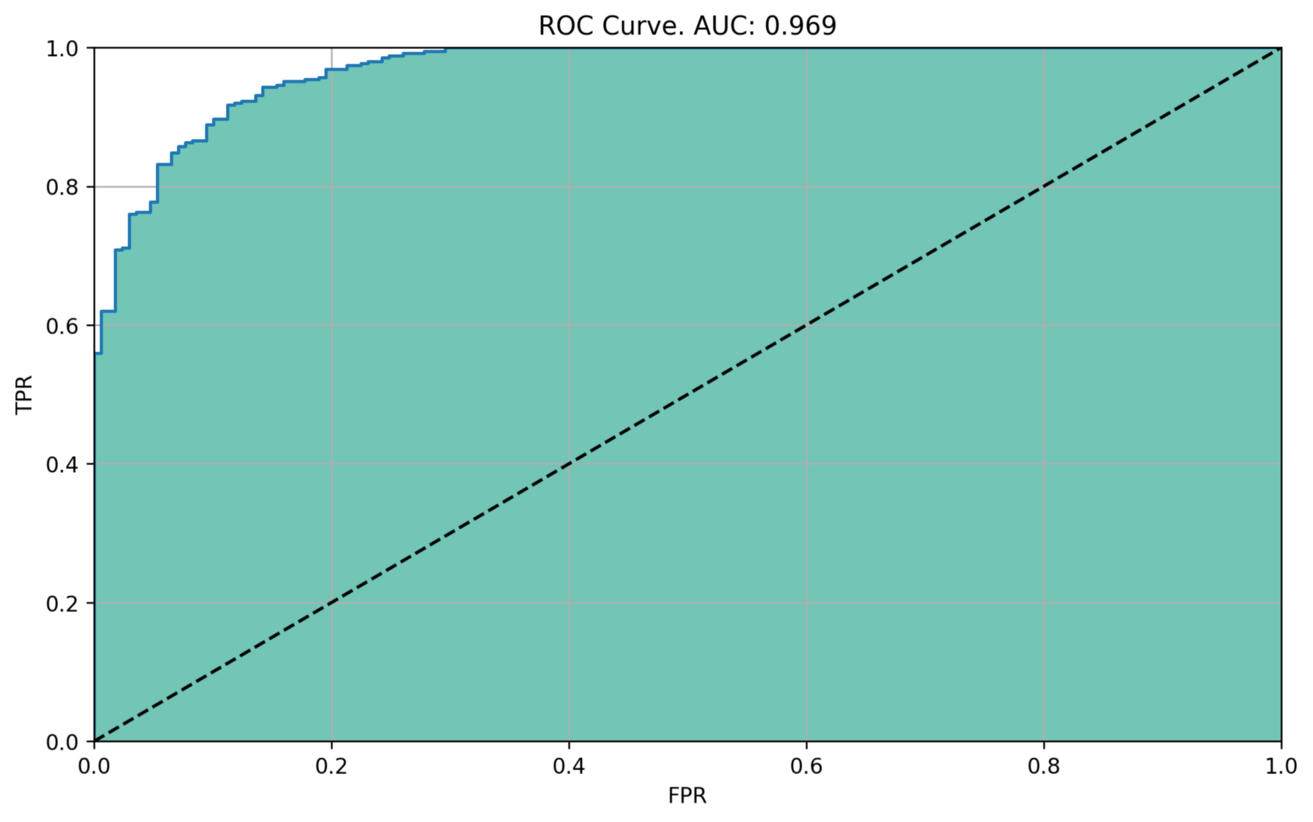

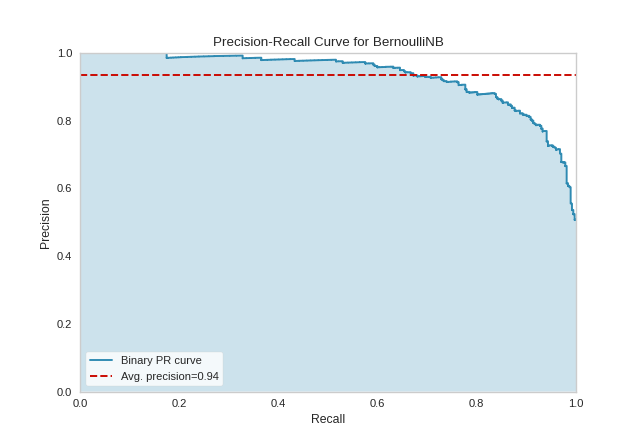

##### На последнем графике удобнее фиксировать одну из метрик для максимизации другой. Также лучше понятна зависимость метрик друг от друга: при увеличении "recall" падает "precision" и наоборот.